In [95]:
import mne
import numpy as np
import matplotlib.pyplot as plt

In [96]:
# load one of the epochs to get the channel names and positions
epoch_path = "/media/8.1/final_data/laurap/epochs/visual_18-epo.fif"
info = mne.read_epochs(epoch_path, preload=False).info

# only keep magnetometers and gradiometers
picks = mne.pick_types(info, meg=True, eeg=False, eog=False, stim=False, exclude='bads')

Reading /media/8.1/final_data/laurap/epochs/visual_18-epo.fif ...


    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-02 (1 x 203) active
        planar-Raw-0.000-120.000-PCA-03 (1 x 203) active
        axial-Raw-0.000-120.000-PCA-01 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-03 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-04 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-05 (1 x 102) active
        axial-Raw-0.000-120.000-PCA-06 (1 x 102) active
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
215 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 9)
9 projection items activated


In [97]:

betas = np.load(f"betas/cross_decoding_10_LDA_sens.npy")

n_sessions, T, C, ncv = betas.shape

In [98]:
# for now take the average betas over the sessions and cross-validation
avg_betas = betas.mean(axis=(0, 3))

# get indices of gradiometers and magnetometers
grad_picks = mne.pick_types(info, meg='grad', eeg=False, eog=False, stim=False, exclude='bads')
mag_picks = mne.pick_types(info, meg='mag', eeg=False, eog=False, stim=False, exclude='bads')

# get the channel names and positions
grad_info = mne.pick_info(info, grad_picks)
mag_info = mne.pick_info(info, mag_picks)

# get the indices to get
grad_idx = [info['ch_names'].index(name) for name in grad_info['ch_names']]
mag_idx = [info['ch_names'].index(name) for name in mag_info['ch_names']]

# get the average betas for gradiometers and magnetometers
avg_betas_grad = avg_betas[:, grad_idx]
avg_betas_mag = avg_betas[:, mag_idx]

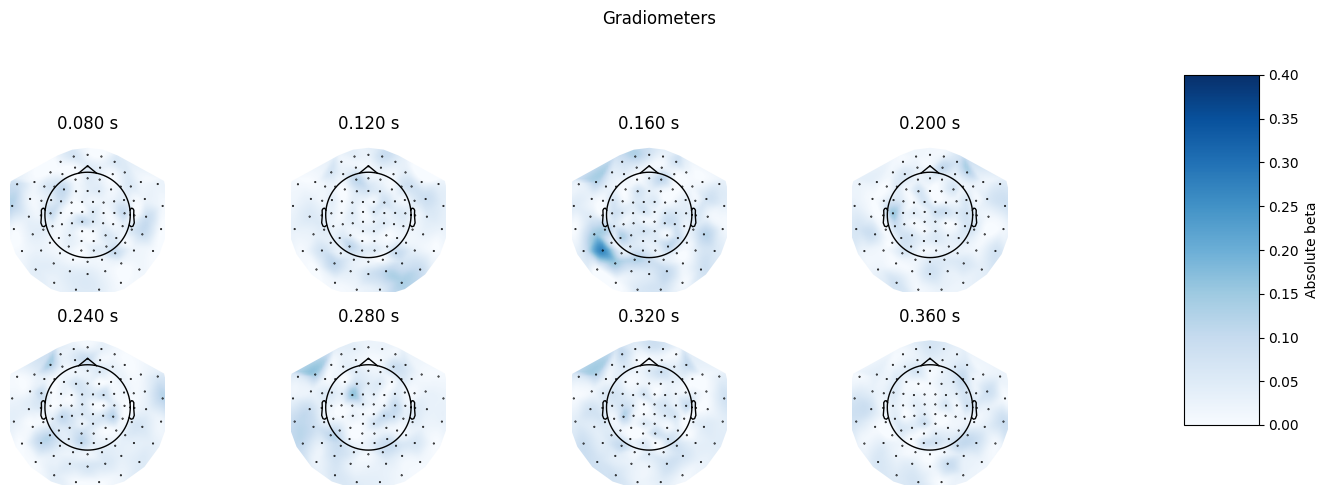

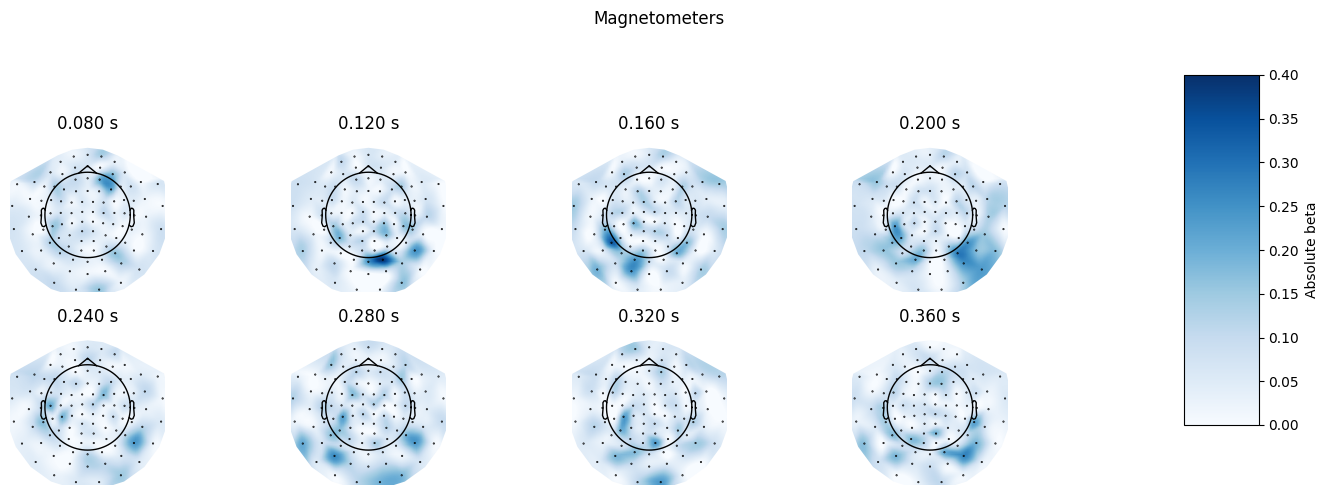

In [99]:
def plot_topomaps(betas, info, timepoints, cmap="Blues", vmax = 0.3, title=None, save_path=None):
    fig, axes = plt.subplots(2, len(timepoints) // 2, figsize=(15, 5))
    for t, ax in zip(timepoints, axes.flatten()):
        im, _ = mne.viz.plot_topomap(betas[t], info, axes=ax, show=False, cmap=cmap, vmin=0, vmax=vmax, contours=0, ch_type=None)
        ax.set_title(f"{t / 250:.3f} s")

    # Adjust layout before adding colorbar
    fig.tight_layout(rect=[0, 0, 0.8, 0.8])  # Adjust rect to leave space for colorbar and title

    # Add colorbar
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='Absolute beta')

    if title:
        fig.suptitle(title, y=0.98)  # Adjust y to place the title above the plots

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()


timepoints = range(20, 100, 10)
cmap = 'Blues'
vmax = 0.4

avg_betas_grad = avg_betas_grad.reshape(T, 102, 2)
avg_betas_grad = avg_betas_grad.mean(axis=2)


plot_topomaps(abs(avg_betas_grad), mag_info, timepoints, cmap=cmap, title ="Gradiometers", vmax=vmax)
plot_topomaps(abs(avg_betas_mag), mag_info, timepoints, cmap=cmap, title ="Magnetometers", vmax=vmax)

In [100]:
avg_betas_grad.shape

(250, 102)

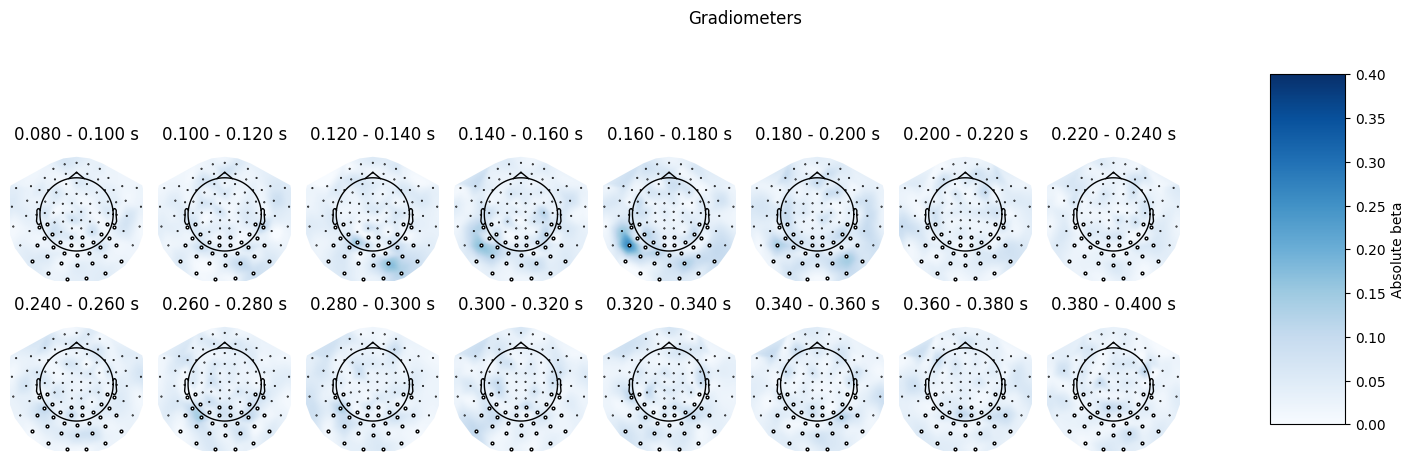

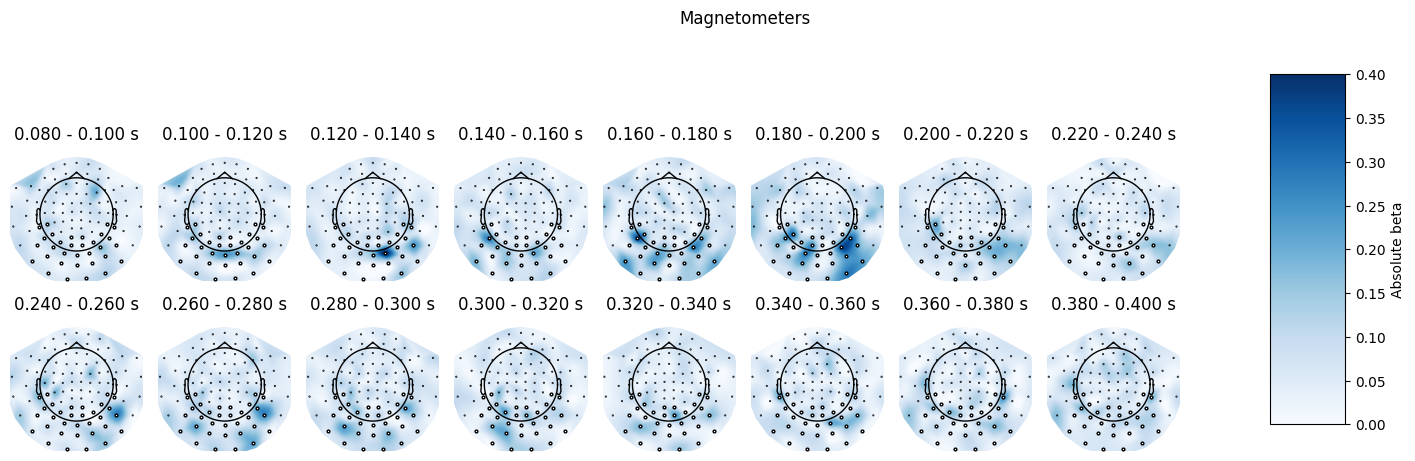

In [110]:
def plot_topomaps_average_range(betas, info, timepoints, cmap="Blues", vmin = 0, vmax = 0.3, mask = None, title=None, save_path=None):
    fig, axes = plt.subplots(2, len(timepoints) // 2, figsize=(15, 5))
    for i, (t, ax) in enumerate(zip(timepoints, axes.flatten())):
        if i < len(timepoints) - 1:
            beta_tmp = betas[t:timepoints[i+1]].mean(axis=0)
            im, _ = mne.viz.plot_topomap(beta_tmp, info, axes=ax, show=False, cmap=cmap, vmin=vmin, vmax=vmax, contours=0, mask=mask, mask_params=dict(markersize = 2), ch_type=None)
            ax.set_title(f"{t / 250:.3f} - {timepoints[i+1] / 250:.3f} s")

    # Adjust layout before adding colorbar
    fig.tight_layout(rect=[0, 0, 0.8, 0.8])  # Adjust rect to leave space for colorbar and title

    # Add colorbar
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='Absolute beta')

    if title:
        fig.suptitle(title, y=0.98)  # Adjust y to place the title above the plots

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()


timepoints = range(20, 101, 5)
cmap = 'Blues'
vmax = 0.4

mask_occipital_grad = np.zeros(len(grad_info['ch_names']), dtype=bool)
mask_occipital_mag = np.zeros(len(mag_info['ch_names']), dtype=bool)


occipital_ch_inds_grad = mne.pick_channels_regexp(grad_info, 'MEG16..|MEG17..|MEG19..|MEG20..|MEG21..|MEG23..|MEG24..|MEG25..')
occipital_ch_inds_mag = mne.pick_channels_regexp(mag_info.ch_names, 'MEG16..|MEG17..|MEG19..|MEG20..|MEG21..|MEG23..|MEG24..|MEG25..')

mask_occipital_grad[occipital_ch_inds_grad] = True
mask_occipital_mag[occipital_ch_inds_mag] = True

for avg_beta, title in zip([avg_betas_grad, avg_betas_mag], ["Gradiometers", "Magnetometers"]):
    plot_topomaps_average_range(abs(avg_beta), mag_info, timepoints, cmap=cmap, title=title, vmax=vmax, mask=mask_occipital_mag)